<a href="https://colab.research.google.com/github/hawa1983/DATA-608/blob/main/DATA_608_HW2_Analytical_Approach_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Can the FED Control Inflation and Maintain Full Employment

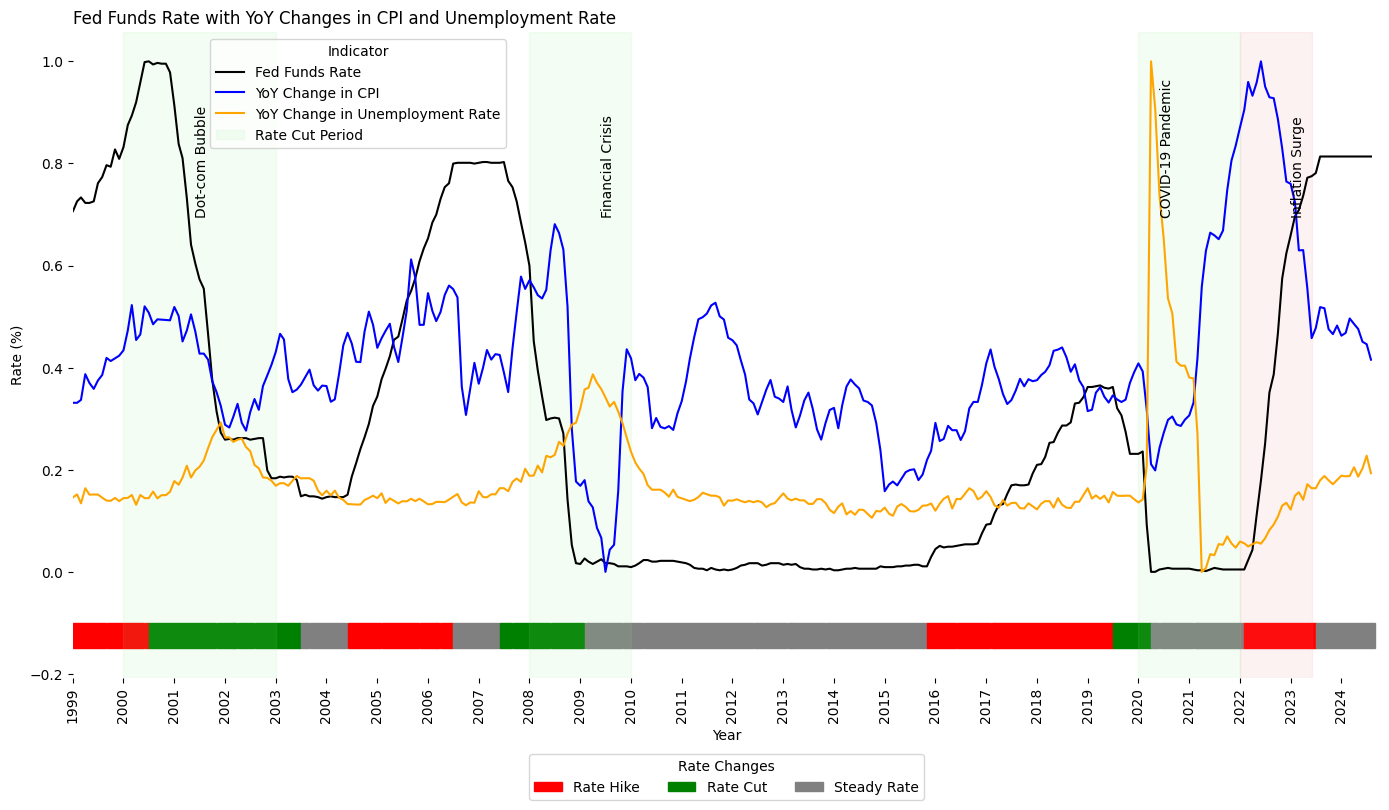

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import yaml
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates  # Import mdates for correct date formatting

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date
start_date = '1998-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Function to fetch data from FRED API
def fetch_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'])
        return df[['date', 'value']]
    else:
        raise Exception(f"Error fetching {series_id} data: {response.status_code}")

# Fetch CPI, Unemployment, and Fed Funds Rate data
cpi_data = fetch_fred_data('CPIAUCSL', api_key, start_date, end_date)
unemployment_data = fetch_fred_data('UNRATE', api_key, start_date, end_date)
fedfunds_data = fetch_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for easier handling
cpi_data.rename(columns={'value': 'CPI'}, inplace=True)
unemployment_data.rename(columns={'value': 'Unemployment_Rate'}, inplace=True)
fedfunds_data.rename(columns={'value': 'FEDFUNDS'}, inplace=True)

# Calculate YoY Percentage Change for CPI and Unemployment
cpi_data['YoY_Change_CPI'] = cpi_data['CPI'].pct_change(periods=12) * 100
unemployment_data['YoY_Change_Unemployment'] = unemployment_data['Unemployment_Rate'].pct_change(periods=12) * 100

# Merge the data
merged_df = pd.merge(cpi_data[['date', 'YoY_Change_CPI']], unemployment_data[['date', 'YoY_Change_Unemployment']], on='date')
merged_df = pd.merge(merged_df, fedfunds_data[['date', 'FEDFUNDS']], on='date')

# Normalize using Min-Max scaling
scaler = MinMaxScaler()
merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']])

# Define color scheme based on time periods
def rate_color_map(date):
    if date >= pd.to_datetime("1999-01-01") and date <= pd.to_datetime("2000-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2000-06-01") and date <= pd.to_datetime("2003-06-01"):
        return 'green'
    elif date >= pd.to_datetime("2004-06-01") and date <= pd.to_datetime("2006-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2007-06-01") and date <= pd.to_datetime("2009-01-01"):
        return 'green'
    elif date >= pd.to_datetime("2015-11-01") and date <= pd.to_datetime("2019-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2019-07-01") and date <= pd.to_datetime("2020-03-01"):
        return 'green'
    elif date >= pd.to_datetime("2022-02-01") and date <= pd.to_datetime("2023-06-01"):
        return 'red'
    else:
        return 'grey'

# Apply color scheme to data
merged_df['RateCategory'] = merged_df['date'].apply(rate_color_map)

# Create the heatmap data
heatmap_data = merged_df[['date', 'RateCategory']]

# Create a larger bottom margin to accommodate the heatmap below the x-axis
plt.figure(figsize=(14, 8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin for heatmap

# Plot the rate change heatmap as tiles on the bottom border of the plot (below x-axis)
for i in range(len(heatmap_data)):
    plt.gca().add_patch(
        plt.Rectangle(
            (heatmap_data.iloc[i]['date'], -0.15),  # Move heatmap below x-axis (-0.15)
            pd.Timedelta(days=30),  # Width in days
            0.05,  # Height of the heatmap tile
            color=heatmap_data.iloc[i]['RateCategory']
        )
    )

# Plot FEDFUNDS, YoY Change in CPI, and YoY Change in Unemployment
sns.lineplot(data=merged_df, x='date', y='FEDFUNDS', label='Fed Funds Rate', color='black')
sns.lineplot(data=merged_df, x='date', y='YoY_Change_CPI', label='YoY Change in CPI', color='blue')
sns.lineplot(data=merged_df, x='date', y='YoY_Change_Unemployment', label='YoY Change in Unemployment Rate', color='orange')

# Highlight periods with colored bands
plt.axvspan(pd.to_datetime("2000-01-01"), pd.to_datetime("2002-12-31"), color="lightgreen", alpha=0.1, label='Rate Cut Period')
plt.axvspan(pd.to_datetime("2008-01-01"), pd.to_datetime("2009-12-31"), color="lightgreen", alpha=0.1)
plt.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2021-12-31"), color="lightgreen", alpha=0.1)
plt.axvspan(pd.to_datetime("2022-01-01"), pd.to_datetime("2023-06-01"), color="lightcoral", alpha=0.1)

# Add labels for significant periods
plt.text(pd.to_datetime("2001-06-01"), 0.7, "Dot-com Bubble", rotation=90)
plt.text(pd.to_datetime("2009-06-01"), 0.7, "Financial Crisis", rotation=90)
plt.text(pd.to_datetime("2020-06-01"), 0.7, "COVID-19 Pandemic", rotation=90)
plt.text(pd.to_datetime("2023-01-01"), 0.7, "Inflation Surge", rotation=90)

# Correctly format the x-axis to display years properly
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Set ticks every 4 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the ticks as years

# Set x-axis limits and labels
plt.xlim(pd.to_datetime("1999-01-01"), pd.to_datetime(end_date))
plt.xticks(rotation=90)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Fed Funds Rate with YoY Changes in CPI and Unemployment Rate', loc='left')

# Custom legend for the heatmap
heatmap_legend = [Patch(color='red', label='Rate Hike'),
                  Patch(color='green', label='Rate Cut'),
                  Patch(color='grey', label='Steady Rate')]

# Legend for lines
line_legend = plt.legend(loc='upper left', bbox_to_anchor=(0.1, 1), title="Indicator")
plt.gca().add_artist(line_legend)

# Add heatmap legend
plt.legend(handles=heatmap_legend, loc='lower center', bbox_to_anchor=(0.5, -0.2), title="Rate Changes", ncol=3)

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()


Global maximum FEDFUNDS occurred on: 2000-12-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2000-12-01 00:00:00
Global maximum Unemployment Rate occurred on: 2002-12-01 00:00:00
Global maximum of Unemployment Rate occurred on: 2002-12-01 00:00:00
Global maximum lag is: 24 months
The linear model equation is:
Lagged Unemployment = 0.2084 * Federal Funds Rate + 0.0763
R-squared: 0.7005


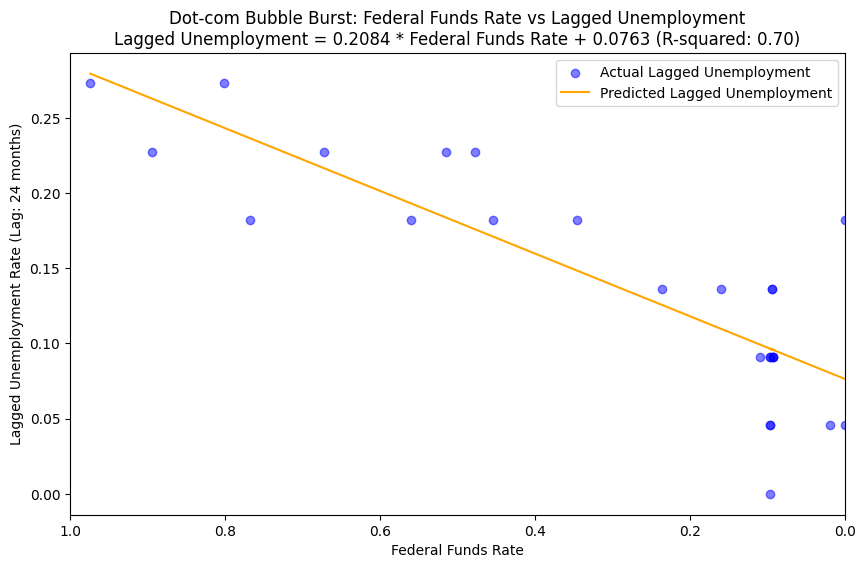

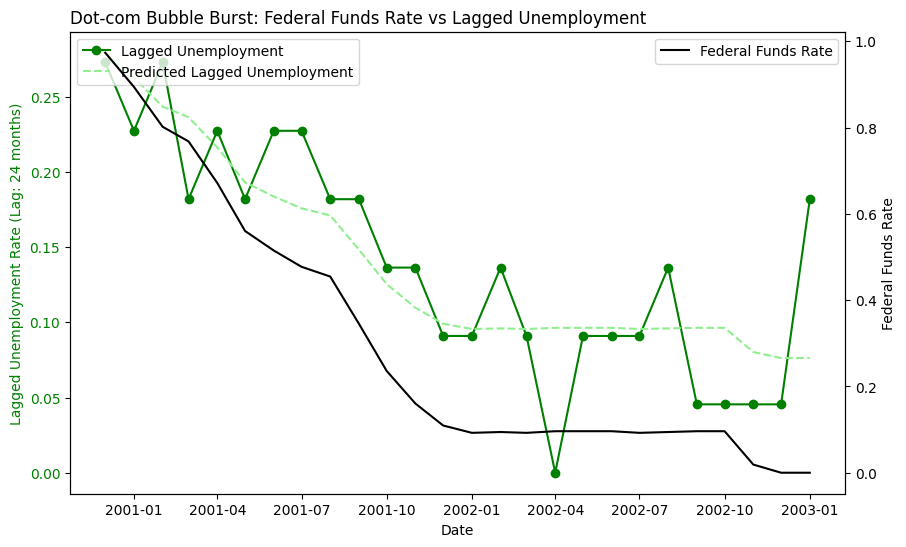

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the initial data fetch
start_date = '1998-12-01'
end_date = '2003-01-01'

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the unemployment or fed data within the provided date range
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Apply a lag to unemployment data
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve unemployment and fed rate data
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(unemployment_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the Unemployment Rate and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['Unemployment Rate', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global maximum of unemployment *within* the same time window
global_max_unemployment_date = find_global_maximum(merged_df, 'Unemployment Rate')
print(f"Global maximum of Unemployment Rate occurred on: {global_max_unemployment_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the Unemployment Rate peak
global_max_lag = (pd.to_datetime(global_max_unemployment_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global maximum lag is: {global_max_lag} months")

# Step 4: Apply the optimal lag to unemployment data
lagged_data = create_lagged_unemployment(merged_df, global_max_lag)

# Step 5: Perform the linear regression with the lagged unemployment data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged Unemployment', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged Unemployment', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
plt.title(f'Dot-com Bubble Burst: Federal Funds Rate vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.show()



# Plot the time series of actual vs predicted lagged unemployment with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged unemployment on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o', color='green')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--', color='lightgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Dot-com Bubble Burst: Federal Funds Rate vs Lagged Unemployment', loc='left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Global maximum FEDFUNDS occurred on: 2000-12-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2000-12-01 00:00:00
Global minimum CPI occurred after 2000-12-01 00:00:00 on: 2001-09-01 00:00:00
Global minimum of CPI occurred after Fed Funds maximum on: 2001-09-01 00:00:00
Global minimum lag is: 9 months
The linear model equation is:
Lagged CPI = -0.6244 * Federal Funds Rate + 0.7634
R-squared: 0.7941


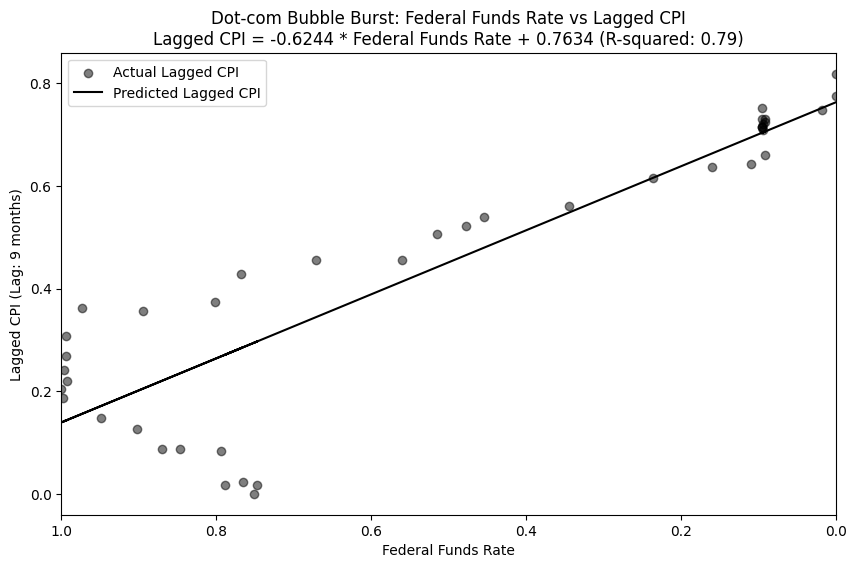

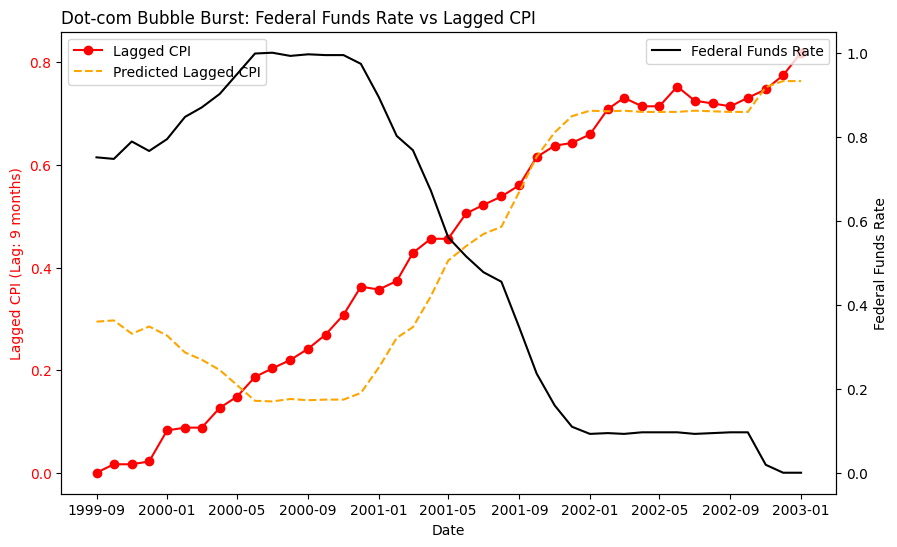

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the initial data fetch
start_date = '1998-12-01'
end_date = '2003-01-01'

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the data
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Directly find the global minimum of CPI data after the global maximum of Fed Funds Rate
def find_global_minimum_after(data, column_name, start_date):
    data_after_start = data[data['Date'] > start_date]  # Filter data after the given date
    smoothed_data = smooth_data(data_after_start[column_name])
    global_min_idx = smoothed_data.idxmin()  # Find the index of the global minimum
    global_min_date = data_after_start.loc[global_min_idx, 'Date']  # Get the date of the global minimum
    print(f"Global minimum {column_name} occurred after {start_date} on: {global_min_date}")
    return global_min_date

# Apply a lag to CPI data (instead of unemployment)
def create_lagged_cpi(data, lag):
    data['Lagged_CPI'] = data['CPI'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve CPI and fed rate data
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the CPI and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['CPI', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global minimum of CPI *after* the global maximum of the Fed Funds Rate
global_min_cpi_date = find_global_minimum_after(merged_df, 'CPI', global_max_fed_date)
print(f"Global minimum of CPI occurred after Fed Funds maximum on: {global_min_cpi_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the CPI minimum
global_min_lag = (pd.to_datetime(global_min_cpi_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global minimum lag is: {global_min_lag} months")

# Step 4: Apply the optimal lag to CPI data
lagged_data = create_lagged_cpi(merged_df, global_min_lag)

# Step 5: Perform the linear regression with the lagged CPI data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged CPI = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line and reverse the x-axis from 1 to 0
plt.figure(figsize=(10, 6))
plt.scatter(X['FEDFUNDS'], y, label='Actual Lagged CPI', color='black', alpha=0.5)
plt.plot(X['FEDFUNDS'], y_pred, label='Predicted Lagged CPI', color='black')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged CPI (Lag: {global_min_lag} months)')
plt.title(f'Dot-com Bubble Burst: Federal Funds Rate vs Lagged CPI\n{equation} (R-squared: {r_squared:.2f})')

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.legend()
plt.show()


# Plot the time series of actual vs predicted lagged CPI with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged CPI on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged CPI', marker='o', color='red')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged CPI (Lag: {global_min_lag} months)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Dot-com Bubble Burst: Federal Funds Rate vs Lagged CPI', loc='left')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


## Financial Crisis

Global maximum FEDFUNDS occurred on: 2007-07-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2007-07-01 00:00:00
Global maximum Unemployment Rate occurred on: 2009-01-01 00:00:00
Global maximum of Unemployment Rate occurred on: 2009-01-01 00:00:00
Global maximum lag is: 18 months
The linear model equation is:
Lagged Unemployment = 0.0643 * Federal Funds Rate + 0.0201
R-squared: 0.3300


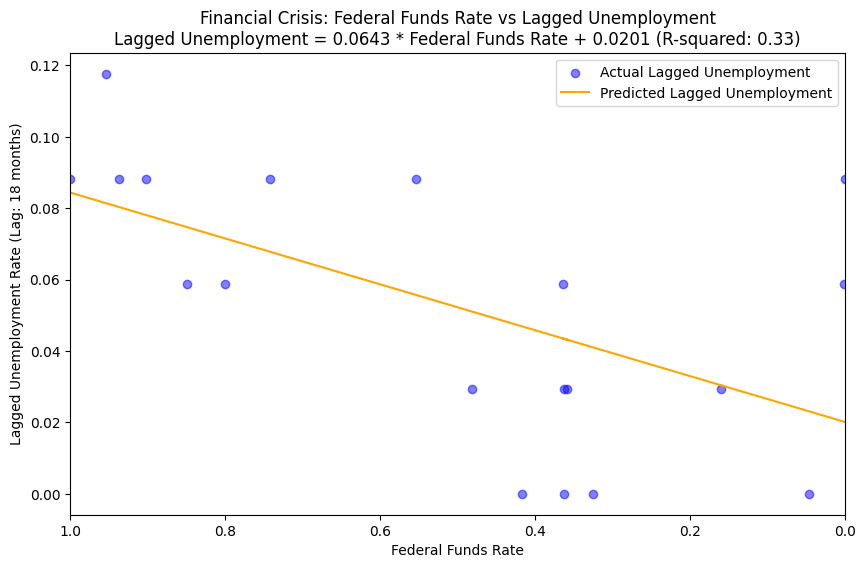

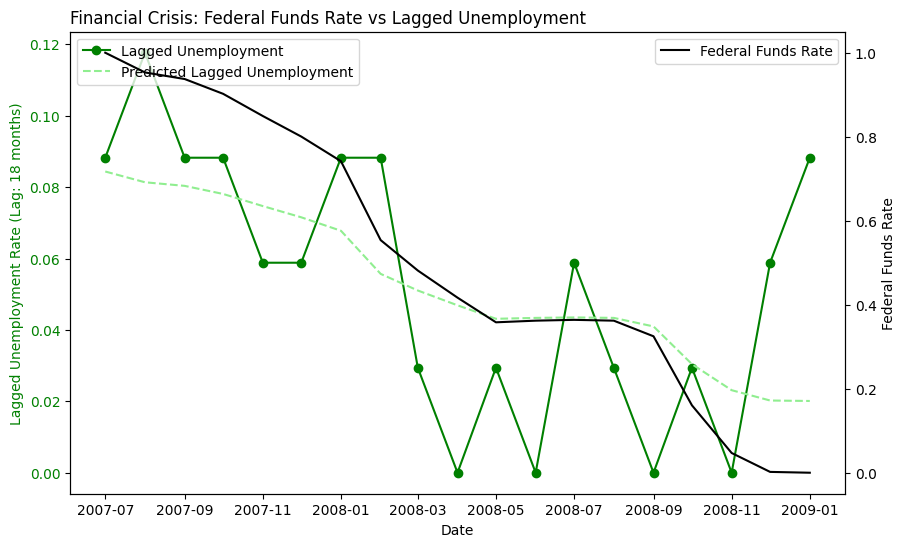

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the data fetch
start_date = '2006-01-01'  # Preceding the financial crisis period
end_date = '2009-01-01'  # End date near the end of the financial crisis and beyond

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the unemployment or fed data within the provided date range
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Apply a lag to unemployment data
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve unemployment and fed rate data
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(unemployment_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the Unemployment Rate and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['Unemployment Rate', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global maximum of unemployment *within* the same time window
global_max_unemployment_date = find_global_maximum(merged_df, 'Unemployment Rate')
print(f"Global maximum of Unemployment Rate occurred on: {global_max_unemployment_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the Unemployment Rate peak
global_max_lag = (pd.to_datetime(global_max_unemployment_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global maximum lag is: {global_max_lag} months")

# Step 4: Apply the optimal lag to unemployment data
lagged_data = create_lagged_unemployment(merged_df, global_max_lag)

# Step 5: Perform the linear regression with the lagged unemployment data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged Unemployment', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged Unemployment', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
plt.title(f'Financial Crisis: Federal Funds Rate vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.show()

# Plot the time series of actual vs predicted lagged unemployment with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged unemployment on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o', color='green')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--', color='lightgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Financial Crisis: Federal Funds Rate vs Lagged Unemployment', loc='left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Global maximum FEDFUNDS occurred on: 2008-02-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2008-02-01 00:00:00
Global minimum CPI occurred on: 2008-02-01 00:00:00
Global minimum of CPI occurred on: 2008-02-01 00:00:00
Global minimum lag is: 0 months
The linear model equation is:
Lagged CPI = -0.6268 * Federal Funds Rate + 0.8114
R-squared: 0.4349


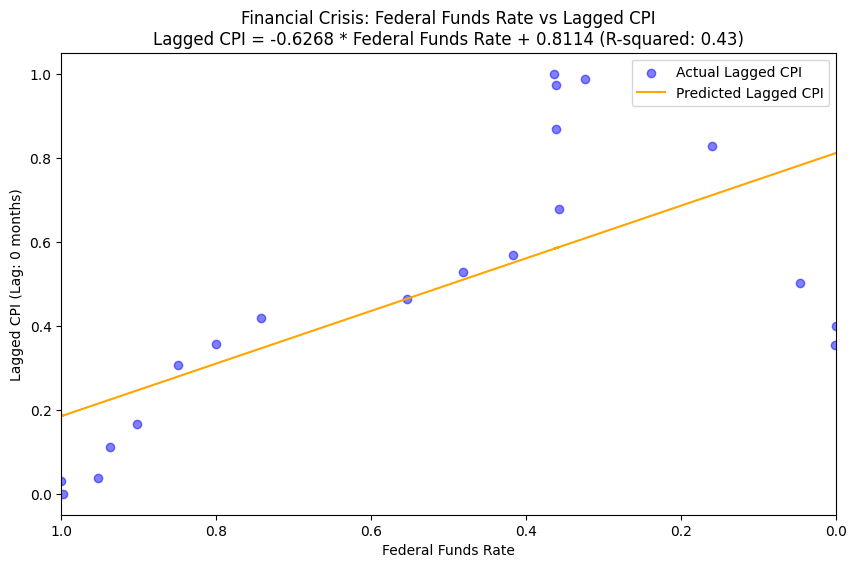

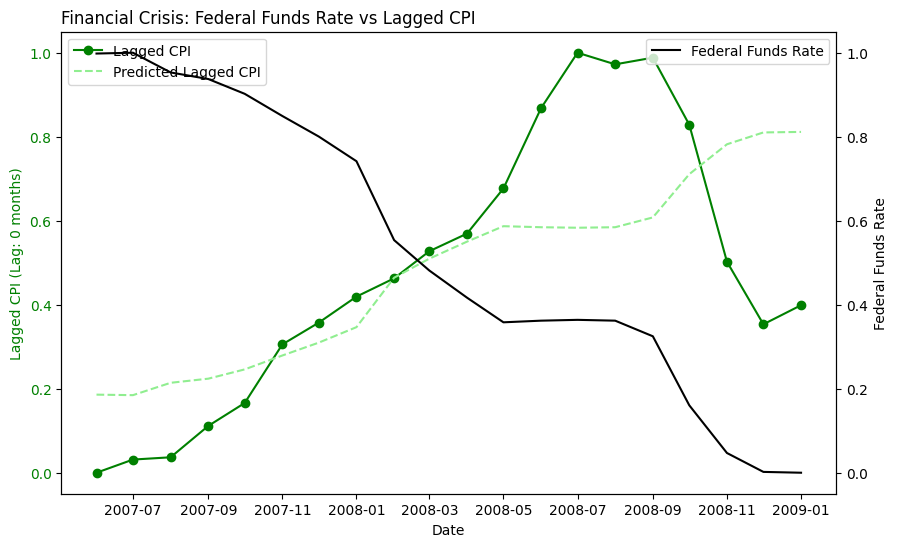

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the data fetch
start_date = '2007-06-01'  # Preceding the financial crisis period
end_date = '2009-01-01'  # End date during the financial crisis period

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Find the global maximum of a column (for FEDFUNDS)
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Find the global minimum of a column (for CPI)
def find_global_minimum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_min_idx = smoothed_data.idxmin()  # Find the index of the global minimum
    global_min_date = data.loc[global_min_idx, 'Date']  # Get the date of the global minimum
    print(f"Global minimum {column_name} occurred on: {global_min_date}")
    return global_min_date

# Apply a lag to CPI data
def create_lagged_cpi(data, lag):
    data['Lagged_CPI'] = data['CPI'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve CPI and fed rate data
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # CPI data
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the CPI and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['CPI', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global minimum of CPI within the same time window
global_min_cpi_date = find_global_minimum(merged_df, 'CPI')
print(f"Global minimum of CPI occurred on: {global_min_cpi_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the CPI minimum
global_min_lag = (pd.to_datetime(global_min_cpi_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global minimum lag is: {global_min_lag} months")

# Step 4: Apply the optimal lag to CPI data
lagged_data = create_lagged_cpi(merged_df, global_min_lag)

# Step 5: Perform the linear regression with the lagged CPI data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged CPI = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged CPI', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged CPI', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged CPI (Lag: {global_min_lag} months)')
plt.title(f'Financial Crisis: Federal Funds Rate vs Lagged CPI\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.show()

# Plot the time series of actual vs predicted lagged CPI with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged CPI on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged CPI', marker='o', color='green')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--', color='lightgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged CPI (Lag: {global_min_lag} months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('Financial Crisis: Federal Funds Rate vs Lagged CPI', loc='left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


## COVID-19 Pandemic

Global maximum FEDFUNDS occurred on: 2019-07-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2019-07-01 00:00:00
Global maximum Unemployment Rate occurred on: 2020-12-01 00:00:00
Global maximum of Unemployment Rate occurred on: 2020-12-01 00:00:00
Global maximum lag is: 17 months
The linear model equation is:
Lagged Unemployment = 0.0211 * Federal Funds Rate + 0.0210
R-squared: 0.3837


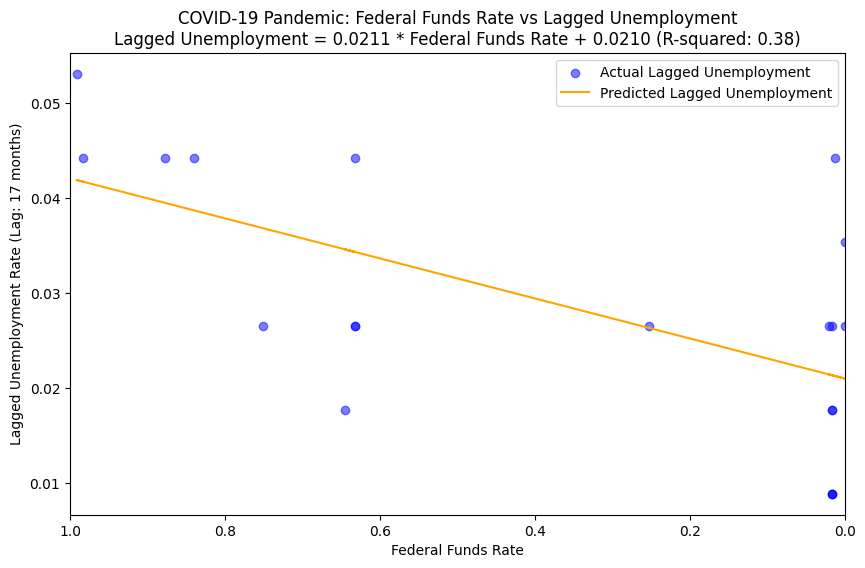

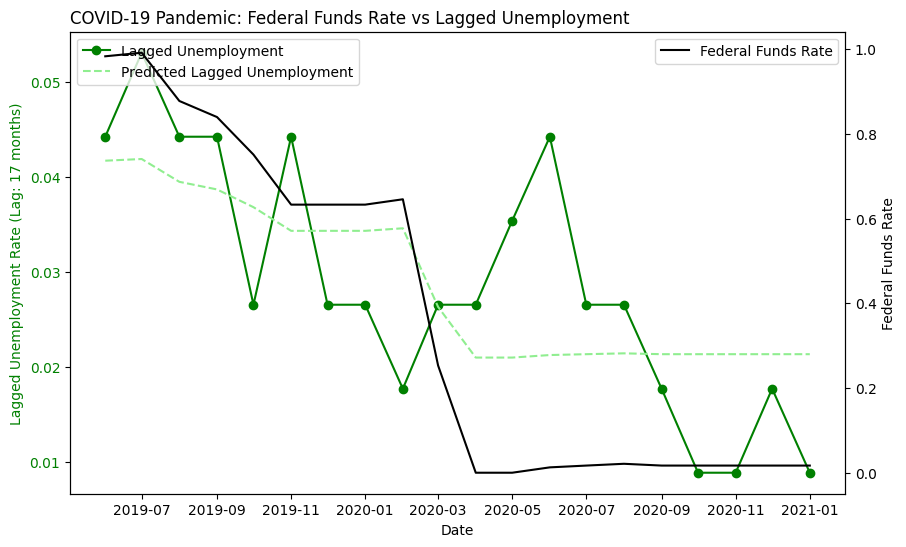

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the COVID-19 pandemic period
start_date = '2018-01-01'  # Preceding the COVID-19 pandemic
end_date = '2021-01-01'  # Through the pandemic and after

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the unemployment or fed data within the provided date range
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Apply a lag to unemployment data
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve unemployment and fed rate data
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(unemployment_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the Unemployment Rate and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['Unemployment Rate', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global maximum of unemployment *within* the same time window
global_max_unemployment_date = find_global_maximum(merged_df, 'Unemployment Rate')
print(f"Global maximum of Unemployment Rate occurred on: {global_max_unemployment_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the Unemployment Rate peak
global_max_lag = (pd.to_datetime(global_max_unemployment_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global maximum lag is: {global_max_lag} months")

# Step 4: Apply the optimal lag to unemployment data
lagged_data = create_lagged_unemployment(merged_df, global_max_lag)

# Step 5: Perform the linear regression with the lagged unemployment data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged Unemployment = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged Unemployment', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged Unemployment', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)')
plt.title(f'COVID-19 Pandemic: Federal Funds Rate vs Lagged Unemployment\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.show()

# Plot the time series of actual vs predicted lagged unemployment with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged unemployment on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o', color='green')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--', color='lightgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged Unemployment Rate (Lag: {global_max_lag} months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('COVID-19 Pandemic: Federal Funds Rate vs Lagged Unemployment', loc='left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Global maximum FEDFUNDS occurred on: 2019-07-01 00:00:00
Global maximum of Fed Funds Rate occurred on: 2019-07-01 00:00:00
Global maximum CPI occurred on: 2020-04-01 00:00:00
Global maximum of CPI occurred on: 2020-04-01 00:00:00
Global maximum lag is: 9 months
The linear model equation is:
Lagged CPI = -0.5350 * Federal Funds Rate + 0.7550
R-squared: 0.6415


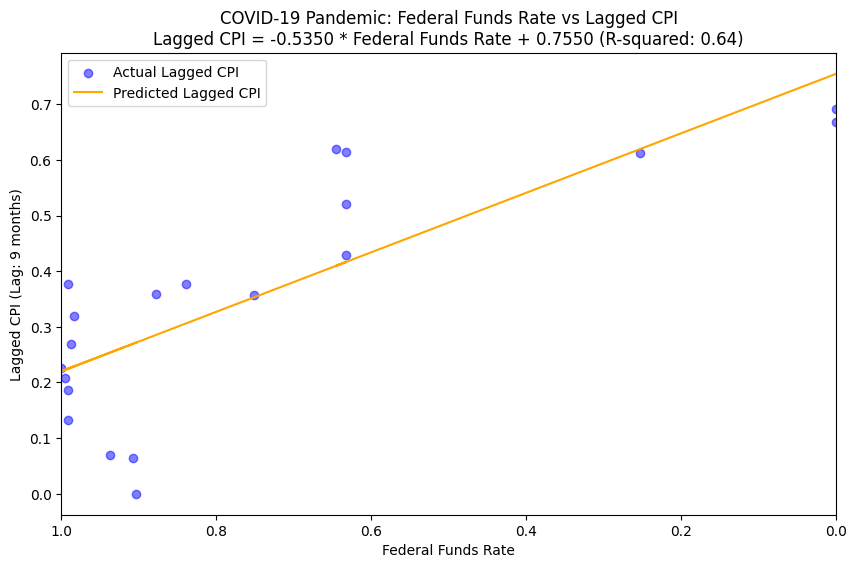

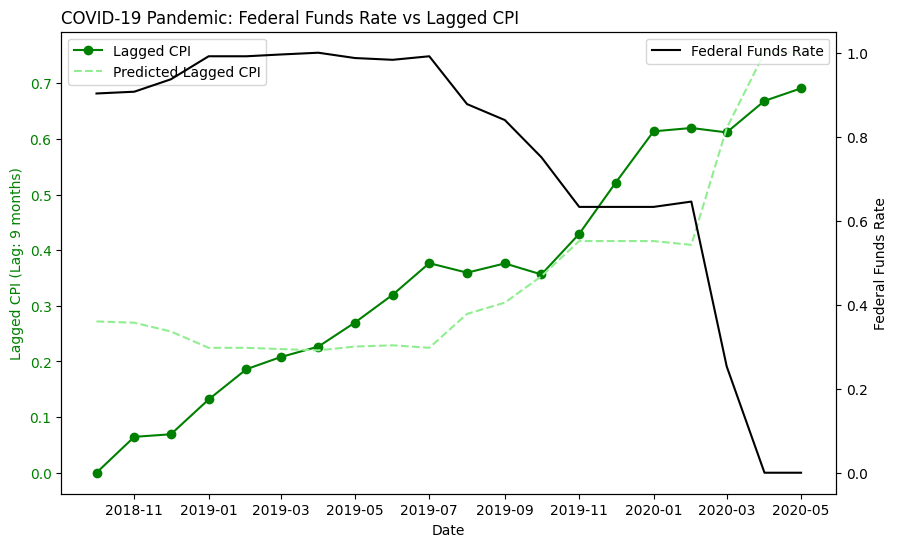

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import yaml

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date for the COVID-19 pandemic period
start_date = '2018-01-01'  # Preceding the COVID-19 pandemic
end_date = '2020-05-01'  # Through the pandemic and after

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Smoothing function (adjust window size for moving average)
def smooth_data(data, window_size=9):
    return data.rolling(window=window_size).mean()

# Directly find the global maximum of the CPI or fed data within the provided date range
def find_global_maximum(data, column_name):
    smoothed_data = smooth_data(data[column_name])
    global_max_idx = smoothed_data.idxmax()  # Find the index of the global maximum
    global_max_date = data.loc[global_max_idx, 'Date']  # Get the date of the global maximum
    print(f"Global maximum {column_name} occurred on: {global_max_date}")
    return global_max_date

# Apply a lag to CPI data
def create_lagged_cpi(data, lag):
    data['Lagged_CPI'] = data['CPI'].shift(lag)  # Apply lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Retrieve CPI and fed rate data
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # CPI data
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, fed_rate_df, on='Date')
merged_df.dropna(inplace=True)

# Normalize the CPI and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['CPI', 'FEDFUNDS']])

# Step 1: Find the global maximum of the Fed Funds Rate and use that as the starting point
global_max_fed_date = find_global_maximum(merged_df, 'FEDFUNDS')
print(f"Global maximum of Fed Funds Rate occurred on: {global_max_fed_date}")

# Step 2: Now find the global maximum of CPI *within* the same time window
global_max_cpi_date = find_global_maximum(merged_df, 'CPI')
print(f"Global maximum of CPI occurred on: {global_max_cpi_date}")

# Step 3: Calculate the lag in months between the Fed Funds Rate peak and the CPI peak
global_max_lag = (pd.to_datetime(global_max_cpi_date) - pd.to_datetime(global_max_fed_date)).days // 30
print(f"Global maximum lag is: {global_max_lag} months")

# Step 4: Apply the optimal lag to CPI data
lagged_data = create_lagged_cpi(merged_df, global_max_lag)

# Step 5: Perform the linear regression with the lagged CPI data
X = lagged_data[['FEDFUNDS']]
y = lagged_data['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Extract coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_

# Display the equation with variable names
equation = f"Lagged CPI = {coefficients:.4f} * Federal Funds Rate + {intercept:.4f}"
print(f"The linear model equation is:\n{equation}")

# Calculate R-squared value
r_squared = r2_score(y, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Lagged CPI', color='blue', alpha=0.5)
plt.plot(X, y_pred, label='Predicted Lagged CPI', color='orange')
plt.xlabel('Federal Funds Rate')
plt.ylabel(f'Lagged CPI (Lag: {global_max_lag} months)')
plt.title(f'COVID-19 Pandemic: Federal Funds Rate vs Lagged CPI\n{equation} (R-squared: {r_squared:.2f})')
plt.legend()

# Set the x-axis limits from 1 to 0
plt.xlim(1, 0)

plt.show()

# Plot the time series of actual vs predicted lagged CPI with Fed Funds Rate on secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the lagged CPI on the primary axis
ax1.plot(lagged_data['Date'], y, label='Lagged CPI', marker='o', color='green')
ax1.plot(lagged_data['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--', color='lightgreen')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Lagged CPI (Lag: {global_max_lag} months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary axis for the Fed Funds Rate
ax2 = ax1.twinx()
ax2.plot(lagged_data['Date'], lagged_data['FEDFUNDS'], label='Federal Funds Rate', color='black')
ax2.set_ylabel('Federal Funds Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legends
plt.title('COVID-19 Pandemic: Federal Funds Rate vs Lagged CPI', loc='left')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
